In [18]:
# loading R packages
library(DESeq2)
library(phyloseq)
library(plyr)
library(dplyr)
library(ggplot2)
library(vegan)
library(functional)

In [17]:
#install.packages("functional")


The downloaded binary packages are in
	/var/folders/d2/qqsv2qxd5fjf4k455pzytwgh0000gn/T//RtmpDnt5uJ/downloaded_packages


In [438]:
# Importing the dataset
df = read.csv("../../../data/Soil_properties/WBNPNWT_Soils_2015_Metadata_File_QIIME.txt",sep="\t",header=TRUE)
# Import the file
df = df[df$Project_ID=="WB15",]
df = df[df$Org_or_Min %in% c("O","M"),]
df = df[,2:dim(df)[2]]
df = df[!duplicated(df$Sample_ID),]
# Get rid of the DNA sample duplicates
row.names(df)=df$Sample_ID
# Fix the rownames

In [510]:
Factors = colnames(df)
FactorClass = c("txt","txt","txt","txt","txt","txt","txt","txt","txt","txt","num","num","num","num","num","num","num","num","num","num","num","num","num","num","num","num","num","num","num","num","num","num","num","num","num","num","num","num","txt","txt","txt","num","txt","txt","num","num","txt","txt","txt","txt","txt","num","num","num","num","num","num","num","num","num","num","num","num","txt","num","num","num","num","num","num","num","num","num","num")
FactorSet = c("seq","sample","sample","sample","sample","sample","sample","seq","seq","seq","soil","soil","soil","soil","soil","soil","soil","soil","soil","soil","soil","soil","soil","soil","soil","soil","soil","soil","soil","soil","soil","soil","soil","soil","soil","soil","soil","soil","class","class","class","class","class","class","class","class","class","class","class","class","sample","severity","severity","severity","severity","severity","severity","severity","severity","severity","severity","severity","severity","severity","codes","codes","codes","codes","codes","codes","codes","codes","codes","codes")
FactorTable = data.frame(Factors=Factors,Class=FactorClass,Set=FactorSet)
# Creating a dataframe with all the factors and whether or not they should be numeric
# And what set of data they belong to
head(FactorTable)

Factors,Class,Set
Barcodes,txt,seq
Sample_Name,txt,sample
Project_ID,txt,sample
Sample_ID,txt,sample
Site_ID,txt,sample
Replicate,txt,sample


In [550]:
### Selecting only numeric properties
df.numeric = df
for (i in 1:length(colnames(df))) {
        if(FactorTable$Class[FactorTable$Factors==colnames(df)[i]]=="num"){
            df.numeric[,i] = as.numeric(paste(df[,i]))
        }
}
# Converts all the factors to numeric data
row.names(df.numeric)=row.names(df)

Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”Warning me

In [565]:
# Filter the samples that are mineral or organic (otherwise all NA)

Org_or_Min = "O"    # Options are "O" or "M"
Dataset = "soil"    # Options are: 'class' 'codes' 'sample' 'seq' 'severity' 'soil'

# Adjusting the dataset so the unburned samples aren't included in burn data
Burned_Unburned = c("Burned")
if (Dataset=="soil"){
    Burned_Unburned = c("Burned","Unburned")
}

# Need this command for the mineral samples, which have, like 3 values for this
df.ord = df.numeric
if (Org_or_Min=="M"){
    df.ord = df.numeric[,colnames(df.numeric)!="TOC_HCL_cruc_pct"]
}

# Need this command for the "codes" or "severity" samples, which have no data for unburned
df.ord = df.ord[df.ord$Org_or_Min==Org_or_Min & df.ord$Burned_Unburned %in% Burned_Unburned,]

# Get only the numeric values
df.ord = df.ord[,colnames(df.ord) %in% FactorTable$Factors[FactorTable$Class == "num"]]



# Select only the factors for the selected dataset
df.ord = df.ord[,colnames(df.ord) %in% FactorTable$Factors[FactorTable$Set == Dataset]]


# Find the columns that have all NAs for numerics
ColsAllNA = c()
for (i in 1:dim(df.ord)[2]){
    ColsAllNA[i]=all(is.na(df.ord[,i]))
}
# Remove cols with all NAs
df.ord = df.ord[,!ColsAllNA]

### Ordination (PCA)
ord = prcomp(na.omit(df.ord), scale=TRUE)

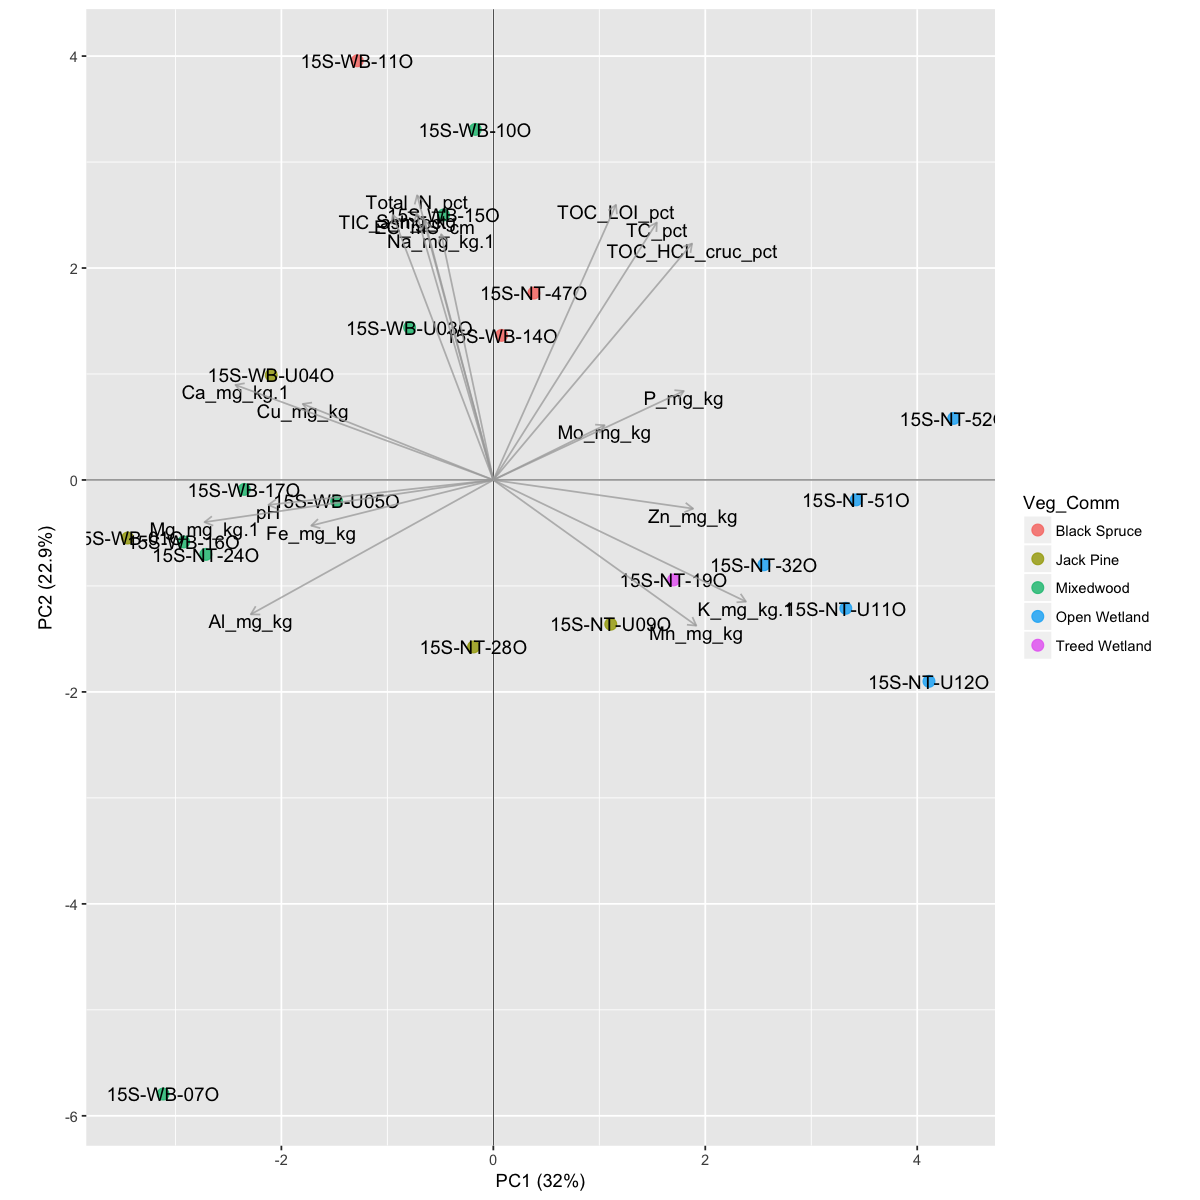

In [566]:
#options(repr.plot.width=10, repr.plot.height=10)

### Plot the ordination
PCbiplot <- function(PC, x="PC1", y="PC2") {
    # Plotting points
    data = data.frame(obsnames=row.names(PC$x), PC$x, df[match(rownames(PC$x), rownames(df)),])
    obsnames = row.names(PC$x)
    p = ggplot(data, aes(x=PC1, y=PC2)) + geom_point(alpha=.8, size=3, aes(color=Veg_Comm)) + geom_text(label=obsnames,size=4)
    p = p + geom_hline(yintercept=0, size=.2) + geom_vline(xintercept=0, size=.2)
    
    # Adding arrows
    datapc = data.frame(varnames=rownames(PC$rotation), PC$rotation)
    mult = min(
        (max(data[,y]) - min(data[,y])/(max(datapc[,y])-min(datapc[,y]))),
        (max(data[,x]) - min(data[,x])/(max(datapc[,x])-min(datapc[,x])))
        )
    datapc = transform(datapc,
            v1 = .7 * mult * (get(y)),
            v2 = .7 * mult * (get(x))
            )
    p = p + coord_equal() + geom_text(data=datapc, aes(x=v1, y=v2, label=varnames), size = 4, vjust=1, color="black")
    p = p + geom_segment(data=datapc, aes(x=0, y=0, xend=v1, yend=v2), arrow=arrow(length=unit(0.2,"cm")), alpha=0.75, color="darkgrey")
    
    # Adding axis labels
    var = PC$sdev^2 / sum(PC$sdev^2)
    p = p + xlab(paste("PC1 (",round(var[1]*100,1),"%)",sep=""))
    p = p + ylab(paste("PC2 (",round(var[2]*100,1),"%)",sep=""))
    
    p
}

PCbiplot(ord)